# fig_egPopHFA

### This notebook generates figures related to population-level analyses of HFA in relation to RT. Main goal is to explore subject by subject patterns of behavior and neural population analyses.



In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 14
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/fig_egPopHFA/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
      
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')

# Collect Group taskstats Data
C = cc.Collection(collection_lbl='all')

C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# get bool masks for motor, visual and reward groups. 
#ret_dict = C.groupElectrodesByTaskStats(print_flag=False)
ret_idx = None
ret_idx_lbl = 'None'

# filter only include good electrodes 
C.filterElectrodes(filtE_bool= np.array(C.isBadElectrode_list)==False)


anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');


# cluster based on features
C.clusterElectrodesByTaskStats()
clus_ret_mat = C.clus_getMasterRetIdxMat(cut_level=21)


ret_idx = None
ret_idx_lbl = 'None'


# # visual clusters (16, 19)
# ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = 37, clus_id_list=[16,19], exclude_flag = False)
# ret_idx_lbl = 'Visual'

# # motor clusters (4,21,22)
# ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = 37, clus_id_list=[4,21,22], exclude_flag = False)
# ret_idx_lbl = 'Motor'

# # visuo-motor clusters (4,16,19,21,22)
#ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = 37, clus_id_list=[4,16,19,21,22], exclude_flag = False)
#ret_idx_lbl = 'VisuoMotor'


def doSubj(subj,ret_idx,ret_idx_lbl):
    # this function plots reports for a single subject
    print(subj)
    
    # init subj object
    S = cc.Subject(subj)
    

    # init subj Collection object 
    self = cc.SubjCollection(subj=subj,filter_bool = ret_idx,filter_bool_lbl = ret_idx_lbl)
    
    
    if self.n_obs < 5:
        print ('SKIPPING '+subj)
    else:
        # not we do not include badTrials in the query so we have the same number of trials for each electrode
        self.getPopulationResponse(pow_frange_lbl='HFA',pow_method='wave',
            pow_evQuery='error==0&fastResponse==0',
            do_zscore=True,
            apply_gauss_smoothing=True,
            gauss_sd_scaling=0.075,num_iters=1,
            apply_time_bins=False,
            time_bin_size_ms=100,
            overwriteFlag=False,feat_list_beh = ['zrrt'],run_light=True)
        
        
        #plot RT
        f = plt.figure()
        ax = plt.subplot(111)
        S.plotRT(ax = ax,evQuery='error==0&fastResponse==0',\
                     plot_type='LATER',
                     plot_median=False,
                     yL=None,
                     model_type='mean_std',color ='0.5',
                     alpha = 0.5,
                     bins = None)
        S.set_axes_rt(ax=ax,plot_type = 'LATER',add_legend=False)
        plt.gca()
        plt.gca().set_title(S.subj)
        save_fig(subj+'-zrrt-'+ret_idx_lbl)
        
        
        # plot explained variance
        self.pop_plotExplainedVar(self.pca_mod)
        num_dim_needed = np.nonzero(np.cumsum(self.pca_mod.explained_variance_ratio_)>0.95)[0][0]
        plt.gca().set_title('num dim needed '+str(num_dim_needed))
        save_fig(subj+'-pcaDim-'+ret_idx_lbl)


        # STOCHASTIC RT VAR
        # plot popStats Regression
        for b in ['zrrt']:
            self.pop_plotPopStats_reg(beh_var_lbl = b,stat_option = 'corrPartial',d_str = 'S')
            plt.gca().set_title('Short delay')
            save_fig(subj+'-popRegS-'+b+'-'+ret_idx_lbl)
            self.pop_plotPopStats_reg(beh_var_lbl = b,stat_option = 'corrPartial',d_str = 'L')
            plt.gca().set_title('Long delay')
            save_fig(subj+'-popRegL-'+b+'-'+ret_idx_lbl)


### illustrate 3d trajectories


In [3]:
%%capture
#illustrate 3d trajectories
subj = 'HUP179'
self = cc.SubjCollection(subj=subj,filter_bool = ret_idx,filter_bool_lbl = ret_idx_lbl)

# not we do not include badTrials in the query so we have the same number of trials for each electrode
self.getPopulationResponse(pow_frange_lbl='HFA',pow_method='wave',
    pow_evQuery='error==0&fastResponse==0',
    do_zscore=True,
    apply_gauss_smoothing=True,
    gauss_sd_scaling=0.075,num_iters=1,
    apply_time_bins=False,
    time_bin_size_ms=100,
    overwriteFlag=False,feat_list_beh = ['zrrt'],run_light=True)

In [ ]:
# 3D TRAJECTORIES IN PCA 
num_trials_to_plot = 15


# SR Traj
plot_option = 'SR'
center_on_origin = False
center_on_response = True
# plot 20 fast trials
self.pop_plot3d(self.popResponse_dict['popMat2d_pc'],\
                trial_len_samp=np.shape(self.popResponse_dict['popMat'])[1],\
                rts_ms= self.popResponse_dict['rt'], \
                targOn_offset_samp = None,ax= None,\
                data_for_cmap = None,\
                plot_option = plot_option,\
                trials_option = 'fast',\
                num_trials_to_plot=num_trials_to_plot,\
                center_on_origin = center_on_origin,
               center_on_response=center_on_response)

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlim(-30,30)
ax.set_ylim(-20,20)
ax.set_zlim(-15,15)

# make traj directory for this traj
# create  dir for eg traj
tragFig_dir = fig_dir+subj+'-egTrajFast-'+str(center_on_response)+'/'
if os.path.exists(tragFig_dir)==False:
     os.mkdir(tragFig_dir)

# rotate the axes and save frames
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.savefig(tragFig_dir+str(angle)+'.png',dpi=300)
    #plt.pause(.001)

# plot 20 slow trials
self.pop_plot3d(self.popResponse_dict['popMat2d_pc'],\
                trial_len_samp=np.shape(self.popResponse_dict['popMat'])[1],\
                rts_ms= self.popResponse_dict['rt'], \
                targOn_offset_samp = None,ax= None,\
                data_for_cmap = None,\
                plot_option = plot_option,\
                trials_option = 'slow',\
                num_trials_to_plot=num_trials_to_plot,\
                center_on_origin = center_on_origin,
               center_on_response=center_on_response)

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlim(-30,30)
ax.set_ylim(-20,20)
ax.set_zlim(-15,15)

# create  dir for eg traj
tragFig_dir = fig_dir+subj+'-egTrajSlow-'+str(center_on_response)+'/'
if os.path.exists(tragFig_dir)==False:
     os.mkdir(tragFig_dir)

# rotate the axes and save frames
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.savefig(tragFig_dir+str(angle)+'.png',dpi=300)
    #plt.pause(.001)


### illustrate brain state representations

In [2]:
subj = 'HUP179'
self = cc.SubjCollection(subj=subj,filter_bool = ret_idx,filter_bool_lbl = ret_idx_lbl)
self.getPopulationResponse(pow_frange_lbl='HFA',pow_method='wave',
    pow_evQuery='error==0&fastResponse==0',
    do_zscore=True,
    apply_gauss_smoothing=True,
    gauss_sd_scaling=0.075,num_iters=1,
    apply_time_bins=False,
    time_bin_size_ms=100,
    overwriteFlag=False,feat_list_beh = ['zrrt'],run_light=True)

/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:3270: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne.Epochs(self.Raw,events=randEv_mne,
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:3187: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:3270: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne.Epochs(self.Raw,events=randEv_mne,
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:3187: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)


Loaded Group isBadElectrode_list  


/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1349: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1373: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1391: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1410: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/home/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1429: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))


In [3]:
#illustrate brainstate matrix (electrodes x time)
# [ ] consider moving to function base

def plotBrainState(self,t):
    #
    brainState_mat = self.pop_mat2vec(self.popResponse_dict['popMat']).T

    samplerate = int(self.popResponse_dict['samplerate'])
    rts = self.popResponse_dict['rt']
    #plt.figure(figsize=(20,20))
    #print(t*samplerate)

    # plot brain state and mark RT
    f = plt.figure()
    ax = plt.subplot(111)
    a = ax.imshow(brainState_mat[:,(t*samplerate):(t*samplerate)+samplerate],cmap='coolwarm')
    plt.colorbar(a)

    # draw vline indicating rt on this trial
    ax.vlines((rts[t]/1000)*samplerate,ax.get_ylim()[0],ax.get_ylim()[1],color = '0.5',linestyle='dashed')
    ax.axis('tight')
    #ax.axis('off')

    # set xticks
    xt = np.linspace(0,self.samplerate,5)
    ax.set_xticks(xt)
    ax.set_xticklabels(np.round(1000*(xt/self.samplerate)).astype('int'))
    ax.set_xlabel('Time from stimulus (ms)')
    ax.set_ylabel('Electrode number')
    ax.set_title('Trial '+str(t)+', RT '+str(np.round(rts[t],2)))
    
    save_fig(subj+'eg_brainstate_singletrial')
plotBrainState(self,t=40)
#for i in range(0,len(self.popResponse_dict['rt'])):
#    plotBrainState(self,t=i)

In [9]:
print(self.pop_mat2vec(self.popResponse_dict['popMat']).T.shape)

(138, 187904)


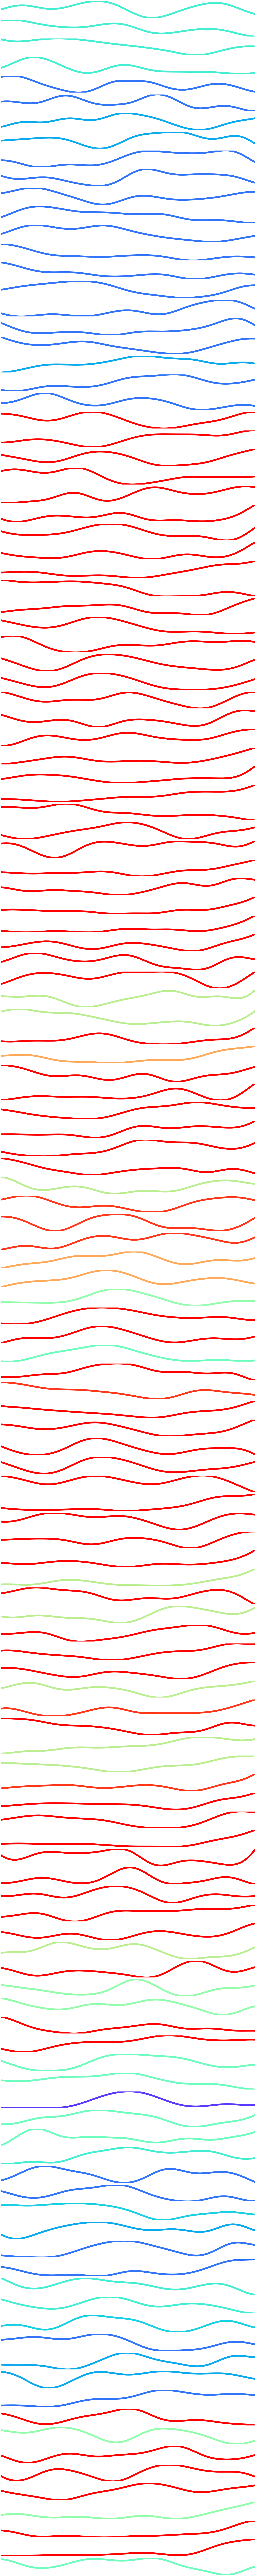

In [14]:

# plot a single electrode over n_trials
brainState_mat = self.pop_mat2vec(self.popResponse_dict['popMat']).T
samplerate = int(self.popResponse_dict['samplerate'])


f = plt.figure(figsize=(20,200))

ax_list = f.subplots(nrows=np.shape(brainState_mat)[0],ncols=1)
t = 40
n_trials = 1

# get color list
subj_ret_idx  = (np.array(C.subj_list) == subj)
c_array = anatDf['roi_color'].to_numpy()[subj_ret_idx]

for e in range(0,np.shape(brainState_mat)[0]):
    ax_list[e].plot(brainState_mat[e,(t*samplerate):(((n_trials-1)+t)*samplerate)+samplerate],linewidth=10,color=c_array[e])
    ax_list[e].axis('off')
    ax_list[e].axis('tight')
plt.tight_layout()
save_fig(subj+'eg_brainwaves')

# e = 20
# t = 35
# self.uElbl_list[e]
# plt.plot(brainState_mat[e,(t*samplerate):((10+t)*samplerate)+samplerate])

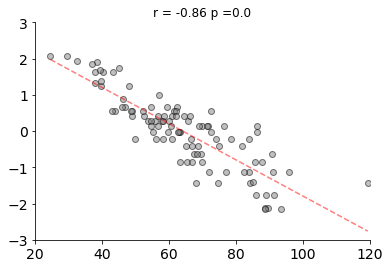

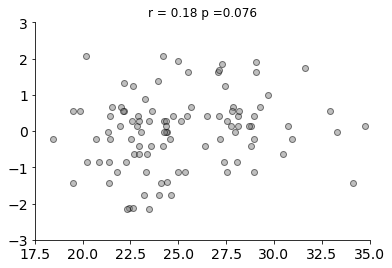

In [79]:
# plot scatter rate vs. rt

rts = self.popResponse_dict['rt']
sr_rate = self.popResponse_dict['SR_rate']
self.plot_scatter(sr_rate,stats.zscore(-1/rts));

sr_dist = self.popResponse_dict['SR_dist']
self.plot_scatter(sr_dist,stats.zscore(-1/rts));


In [3]:
# HUP179
doSubj(subj='HUP179',ret_idx=ret_idx,ret_idx_lbl=ret_idx_lbl)

HUP179


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2531: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=False,verbose=False))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2445: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2531: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=False,verbose=False))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2445: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)


Loaded Group isBadElectrode_list  


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1255: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1279: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1297: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1316: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1335: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))


In [6]:
doSubj(subj='HUP146',ret_idx=ret_idx,ret_idx_lbl=ret_idx_lbl)

HUP146


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2531: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=False,verbose=False))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2445: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2531: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=False,verbose=False))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2445: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)


Loaded Group isBadElectrode_list  


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1255: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1279: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1297: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1316: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))


In [7]:
doSubj(subj='HUP133',ret_idx=ret_idx,ret_idx_lbl=ret_idx_lbl)

HUP133


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2531: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=False,verbose=False))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2445: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2531: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=False,verbose=False))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2445: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mne_all = mne.Epochs(self.Raw,events=mne_ev,tmin = start_s,tmax=stop_s,preload=False,verbose=False)


Loaded Group isBadElectrode_list  


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1255: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1279: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1297: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1316: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1335: RuntimeWarning: divide by zero encountered in log
  err_ = -np.sum(np.log(norm.pdf(self.rrts_to_fit)))
